# Capstone Milestone 3: Federal Funds Rate Regression Modeling
Nicholas Pham

## Introduction

In this project we will construct models for the Federal Funds Effective Rate, which we will just call the Federal Funds Rate (FFR). This is a rate determined by the market, similar to stock prices in the stock market. The FFR is a key tool used in monetary policy that influences economic activity. The Federal Reserve sets a Target for the FFR, then performs operations such as trading bonds to adjust the FFR, bringing it closer to the Target. Predicting the FFR benefits educators, economists, investors, financial institutions, and policy planners.

This project aims to first reproduce regression models predicting the FFR using Taylor’s Rule, a policy guideline by John Taylor from Stanford in 1993 and a modification of this used by researcher Alper D. Karakas, the equations of which are derived in Karkas’ (2023) paper, “Reevaluating the Taylor Rule with Machine Learning.”

We will then attempt to construct other models by adding the Target and Unemployment Rate to the Taylor Model to see if the addition of new features can improve the performance of regression models in predicting the Federal Funds Effective Rate. We choose to build off the Taylor Model as this is the foundational model and Karakas (2023) found little difference in performance between this model and their model.

We will also check the assumptions of regression for each model.

# Setup

## Import Libraries, Functions, and Classes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, linear_rainbow
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy.stats.mstats import winsorize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

## Define Functions

In [2]:
def fit_ols_model(X, y, model_name):
    """Fits an OLS Regression model for the given variables and returns predictions."""
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Get predictions
    y_pred = model.predict(X)
    return model, y_pred


def calculate_vif(X, model_name):
    """Calculates Variance Inflation Factors (VIFs)."""
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


def error_metrics(y, y_pred):
    """Computes error metrics."""
    
    mse = round(mean_squared_error(y, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    mae = round(mean_absolute_error(y, y_pred), 3)
    mpe = round(np.mean((y - y_pred) / y) * 100, 3)
    mape = round(np.mean(np.abs((y - y_pred) / y)) * 100, 3)
    r2 = r2_score(y, y_pred)
    return {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Mean Percentage Error": mpe,
        "Mean Absolute Percentage Error": mape,
        "R-Squared": r2
    }


def find_resid_sum(y, y_pred):
    """Function to compute the Sum of Residuals."""
   
    rs = np.sum(y - y_pred)
    return rs

    
def find_sae(y, y_pred):
    """Function to compute the Sum of Absolute Errors."""
    
    sae = np.sum(np.abs(y - y_pred))
    return sae


def fit_nn_model(X, y, model_name):
    """Fits a Neural Network model for the given variables and returns predictions and model."""
    
    # Set the input dimension
    input_dim = X.shape[1]

    # Define the neural network with an explicit Input layer
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(6, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile the model and fit
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(X, y, epochs=50, batch_size=5, verbose=0)

    # Get predictions
    y_pred = model.predict(X).flatten()
    return model, y_pred, history

# Data Wrangling

In [3]:
# Define a dictionary with datasets and their URLs
datasets = {
    "ffer": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFER.csv",
    "pgdp": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/PGDP.csv",
    "rgdp": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/RGDP.csv",
    "cpi": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/CPI.csv",
    "fftr_lower": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFTR_lower.csv",
    "fftr_upper": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFTR_upper.csv",
    "fftr_old": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFTR_old.csv",
    "unrate": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/UNRATE.csv"
}

# Iterate and load datasets
for name, url in datasets.items():
    globals()[name] = pd.read_csv(url, parse_dates=["observation_date"])
    print(f"{name} dataset loaded successfully.")

ffer dataset loaded successfully.
pgdp dataset loaded successfully.
rgdp dataset loaded successfully.
cpi dataset loaded successfully.
fftr_lower dataset loaded successfully.
fftr_upper dataset loaded successfully.
fftr_old dataset loaded successfully.
unrate dataset loaded successfully.


In [4]:
# Iterate through the dataset names in the dictionary
for name in datasets.keys():
    # Access the DataFrame using globals()
    dataframe = globals()[name]
    duplicates = dataframe[dataframe.duplicated(keep=False)] 
    if not duplicates.empty:
        print(f"'{name}' has {len(duplicates)} duplicate rows:")
        print(duplicates)
    else:
        print(f"'{name}' has no duplicate rows.")

'ffer' has no duplicate rows.
'pgdp' has no duplicate rows.
'rgdp' has no duplicate rows.
'cpi' has no duplicate rows.
'fftr_lower' has no duplicate rows.
'fftr_upper' has no duplicate rows.
'fftr_old' has no duplicate rows.
'unrate' has no duplicate rows.


## Feature Extraction

In [5]:
# The data for CPI can be used to find inflation rates. 
# This is done to obtain a seasonally adjusted inflation dataset that isn't available on FRED.
inflation = pd.DataFrame()
inflation["observation_date"] = cpi["observation_date"] 
inflation["Inflation"] = cpi["CPIAUCSL"].pct_change(periods=12) * 100
inflation.dropna(inplace=True)

# The Federal Funds Target Rate (FFTR) is set by the Federal Reserve. 
# The Fed used to set a single value as the target, but they shifted to setting a range.
# Find the midpoint of the range.

fftr_midpoint = pd.DataFrame()
fftr_midpoint["observation_date"] = fftr_upper["observation_date"] 
fftr_midpoint["Target"] = fftr_upper["DFEDTARU"] - fftr_lower["DFEDTARL"]

# Combine the midpoint with the old FFTR to get a complete FFTR dataset.
fftr_old = fftr_old.rename(columns = {"observation_date": "observation_date", "DFEDTAR": "Target"})
fftr = pd.concat([fftr_old, fftr_midpoint])

## Resample and Merge Data

In [6]:
# Resample datasets to daily frequency.
inflation = inflation.set_index("observation_date").resample("D").ffill().reset_index()
pgdp = pgdp.set_index("observation_date").resample("D").ffill().reset_index()
rgdp = rgdp.set_index("observation_date").resample("D").ffill().reset_index()
unrate = unrate.set_index("observation_date").resample("D").ffill().reset_index()

# Merge the dataframes
df = ffer.merge(inflation, on="observation_date", how="outer") \
        .merge(pgdp, on="observation_date", how="outer") \
        .merge(rgdp, on= "observation_date", how="outer") \
        .merge(unrate, on="observation_date", how="outer") \
        .merge(fftr, on="observation_date", how="outer")

# Set date as an index and rename the columns
df = df.set_index("observation_date")
df.columns = ["Federal Funds Rate", "Inflation (%)", "Potential GDP", "GDP", "Unemployment", "Target"]

# Print the dataframe
df.head()

,Federal Funds Rate,Inflation (%),Potential GDP,GDP,Unemployment,Target
observation_date,,,,,,
1947-01-01,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-02,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-03,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-04,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-05,NaN,NaN,NaN,2182.681,NaN,NaN


All datasets were obtained from the Federal Reserve Economic Database (FRED). Links to each dataset are in the reference list at the bottom of the Notebook.

We will need to derive some more features:

Inflation gap: Inflation - Inflation target 

Output gap: Real GDP - Potential GDP

Inflation target is set at 2% by the Federal Reserve and is therefore treated as such our models (Karakas, 2023).

## Further Feature Extraction and Range Selection

In [7]:
# Find the inflation gap and output gap and add them to the dataframe
df["Inflation Gap"] = df["Inflation (%)"] - 2
df["Output Gap"] = df["GDP"] - df["Potential GDP"]

# Find Inflation Lag and Output Gap Lag for Karakas Model
df["Inflation Lag"] = df["Inflation (%)"].shift(1)
output_gap_lag = df["Output Gap"].shift(1)

# Create a percentage versions of Output Gap Lag and Inflation Lag for Karakas Model
df["Output Gap Lag %"] = (output_gap_lag / df["Potential GDP"]) * 100

# Drop rows with missing values from table
df.dropna(inplace=True)

# Drop Potential GDP and GDP columns as they are not needed
df = df.drop(["Potential GDP", "GDP"], axis=1)

## Check for Duplicates and Missing Values

In [8]:
duplicates = df.index.duplicated(keep=False)
print(df[duplicates])

Empty DataFrame
Columns: [Federal Funds Rate, Inflation (%), Unemployment, Target, Inflation Gap, Output Gap, Inflation Lag, Output Gap Lag %]
Index: []


In [9]:
print(df.isna().sum())

Federal Funds Rate    0
Inflation (%)         0
Unemployment          0
Target                0
Inflation Gap         0
Output Gap            0
Inflation Lag         0
Output Gap Lag %      0
dtype: int64


Karakas (2023) used vectors for the variables and changed the values to percentages. We need to create features to match this so that we can replicate the Karakas Model. We use first lagged variables as our vectors. Since the values of each of our variables can vary in numerical size, we apply Standard Scaling to the variables we will use for modeling to prevent the differences in size from affecting the models and their predictions.

We checked for duplicate rows earlier, but there were none. We checked again after merging the data sets. We dealt with missing values from the dataset by removing them completely.

## Outlier Handling

In [10]:
# Define the percentage of extreme values to cap
winsor_limits = (0.05, 0.05)

# Apply Winsorization to all numeric columns except the dependent variable
for col in df.columns:
    if col != "Federal Funds Rate":
        lower = np.percentile(df[col], winsor_limits[0] * 100)
        upper = np.percentile(df[col], 100 - winsor_limits[1] * 100)
        df[col] = np.clip(df[col], lower, upper)

Here, we capped extreme values using Winsorization. We set the percentage of extreme values to cap at 5%, which should remove most outliers with massive gaps from the rest of the data.

## Check Data Types

In [11]:
# Check the types of each variable
print(df.dtypes)

Federal Funds Rate    float64
Inflation (%)         float64
Unemployment          float64
Target                float64
Inflation Gap         float64
Output Gap            float64
Inflation Lag         float64
Output Gap Lag %      float64
dtype: object


The data is entirely in float64, a numerical data type, with data types consistent across feature. 

# Exploratory Data Analysis (EDA)

In [12]:
# Print the first 5 values of the dataframe
df.head()

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
observation_date,,,,,,,,
1982-09-27,10.18,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-09-28,9.70,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-09-29,9.88,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-09-30,12.17,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-10-01,10.87,5.032120,9.5,9.0625,3.032120,-596.113113,4.940924,-4.532054


In [13]:
# Print the last 5 values of the dataframe
df.tail()

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
observation_date,,,,,,,,
2024-09-27,4.83,2.432541,4.1,0.25,0.432541,311.848,2.432541,1.867123
2024-09-28,4.83,2.432541,4.1,0.25,0.432541,311.848,2.432541,1.867123
2024-09-29,4.83,2.432541,4.1,0.25,0.432541,311.848,2.432541,1.867123
2024-09-30,4.83,2.432541,4.1,0.25,0.432541,311.848,2.432541,1.867123
2024-10-01,4.83,2.571403,4.1,0.25,0.571403,311.848,2.432541,1.867123


In [14]:
# Print the shape of the dataframe, showing the number of rows (observations) and columns
print(df.shape)

(15346, 8)


In [15]:
# Compute Summary Statistics
df.describe()

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
count,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000
mean,3.770183,2.829089,5.912003,3.393910,0.829089,-128.803404,2.829244,-0.919336
std,3.041177,1.265226,1.648995,3.069481,1.265226,279.093430,1.265339,1.809887
min,0.040000,0.653121,3.700000,0.250000,-1.346879,-676.427716,0.653121,-4.532054
25%,0.660000,1.795911,4.600000,0.250000,-0.204089,-297.319722,1.795911,-2.138757
50%,3.770000,2.773597,5.600000,3.000000,0.773597,-105.140969,2.781922,-0.808115
75%,5.740000,3.669725,7.000000,5.750000,1.669725,68.930863,3.669725,0.543627
max,16.170000,5.317419,9.500000,9.062500,3.317419,311.848000,5.317419,1.867123


## Plots of Data Over Time

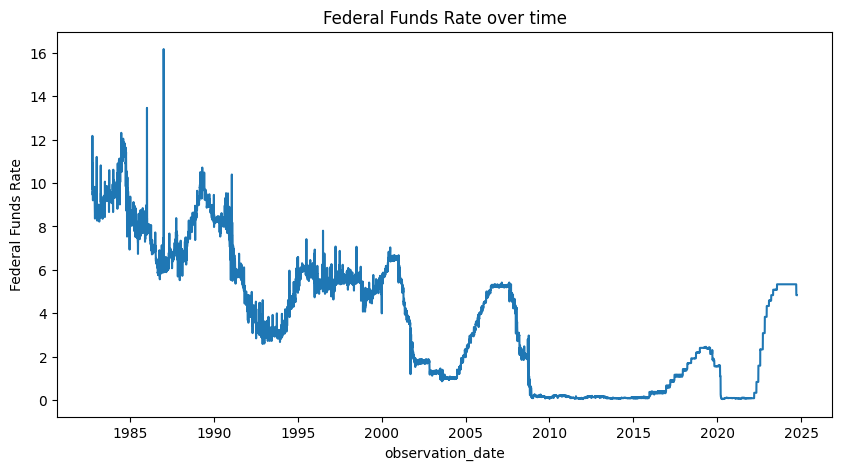

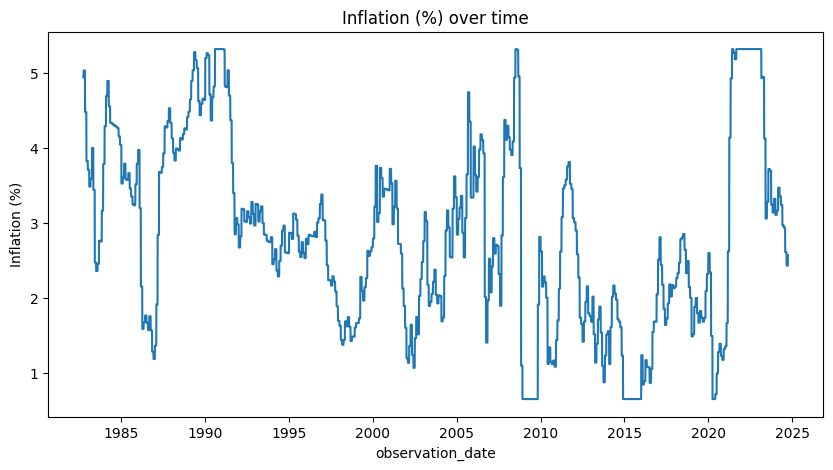

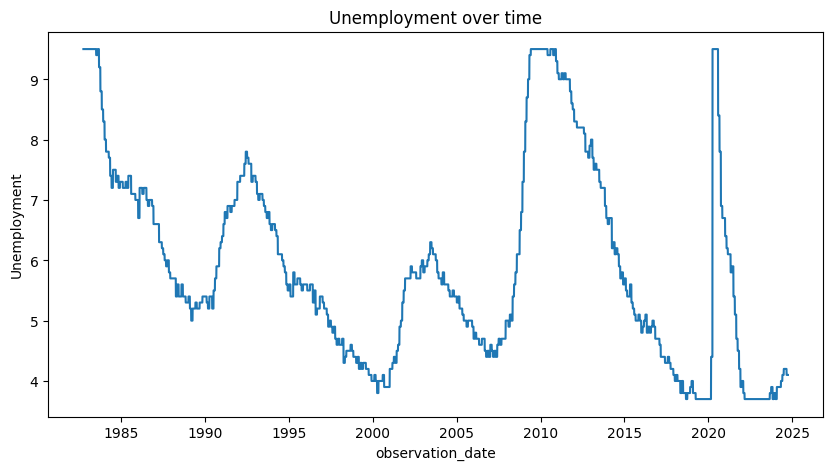

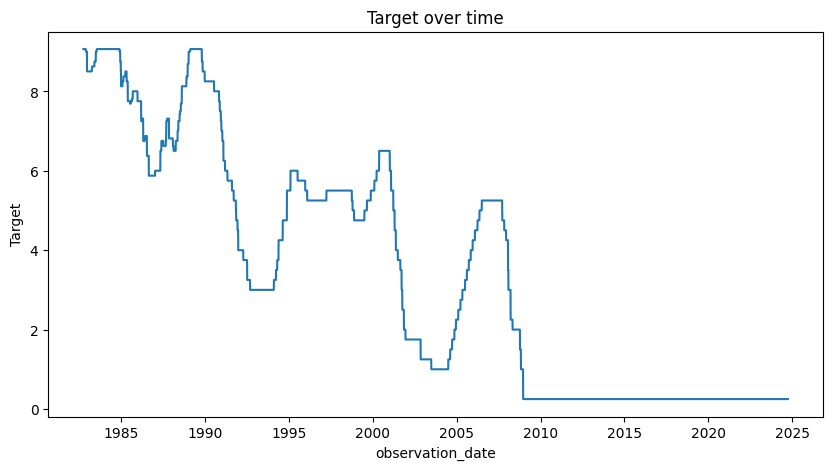

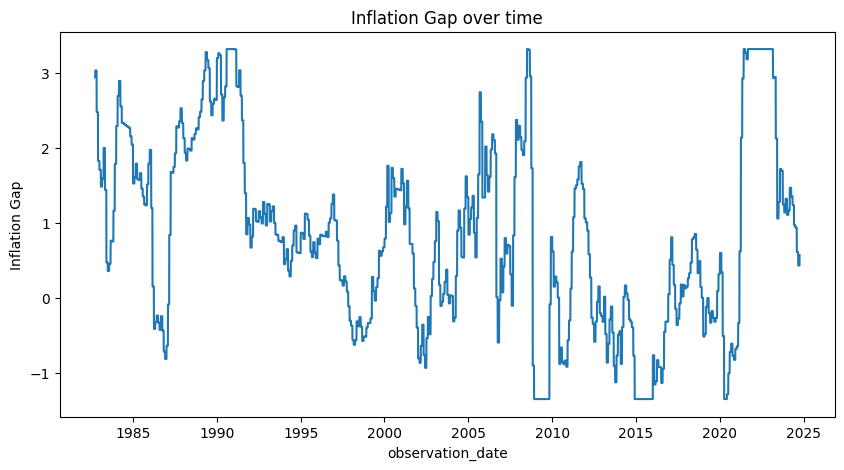

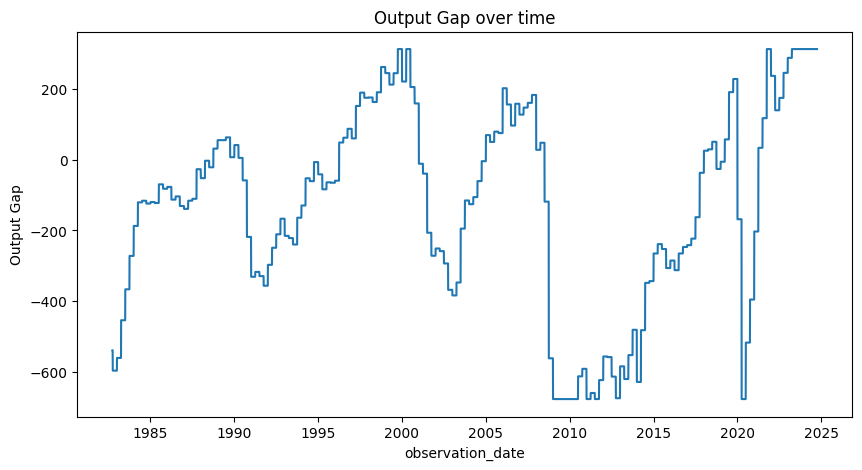

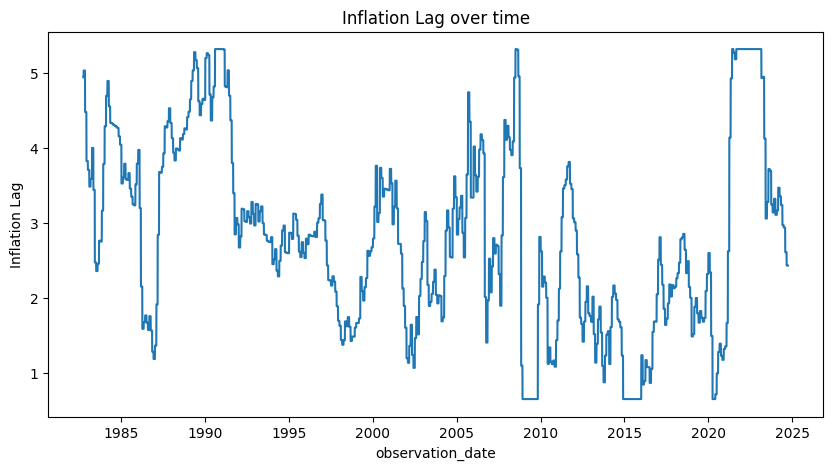

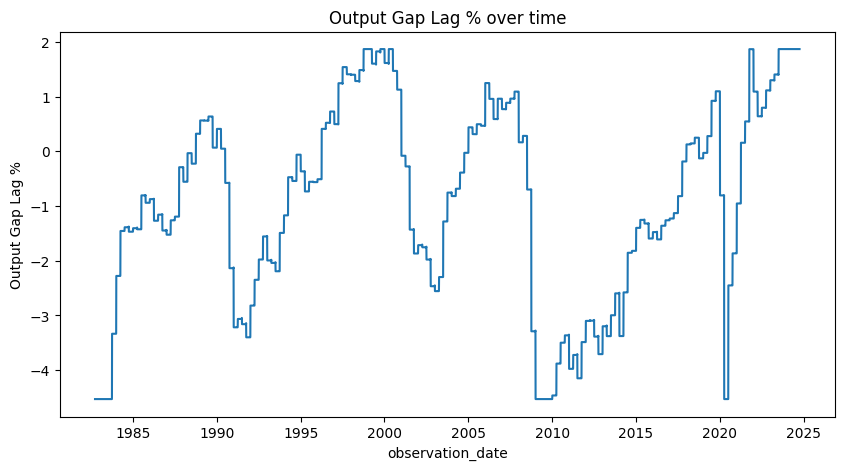

In [16]:
for column in df.columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(df[column])
    plt.title(f"{column} over time")
    plt.show()

The FFR and Target have been steadily decreasing since the 1980s. Inflation, Output Gap, and Unemployment have roughly remained around a constant level over time, despite having some sharp rises or drops.

## Correlation Heatmap

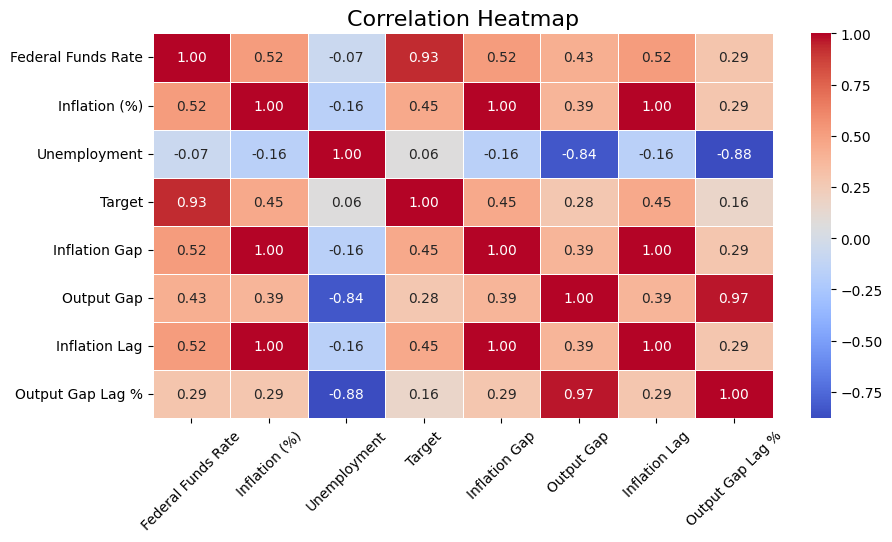

In [17]:
# Construct a Correlation Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(
    df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.show()

Inflation, Inflation Gap, and Inflation Lag are perfectly correlated to each other, while Output Gap and Output Gap Lag (%) are very strongly correlated, which is expected. We will not be trying any models that use more than 1 in each set as predictors at a time.

Unemployment and Output Gap are strongly correlated, so we will need to watch out for these when checking the Variance Inflation Factors (VIFs) for multicollinearity issues.

Target is highly correlated with our dependent variable, Federal Funds Rate, and we expect it to have the biggest impact on predictive performance of the model. Other features generally have between 40% and 50% correlation with the dependent variable, which is moderate. Unemployment has almost 0 correlation with the dependent variable which could mean low impact on predictive performance or a non-linear relationship. 

# OLS Modeling

The variables used for each regression Model are listed as follows:

Taylor's Rule Model: 

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap

Karakas Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap Lag %, Inflation Lag (%)
    
Target Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Target
    
Unemployment Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Unemployment
    
Both Model (uses both Unemployment and Target):

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Target, Unemployment

In [18]:
# Apply Robust Scaler to independent variables
scaler = MinMaxScaler()
df_vars = ["Unemployment", "Target", "Inflation Gap", "Output Gap", "Output Gap Lag %", "Inflation Lag"]
df[df_vars] = scaler.fit_transform(df[df_vars])

The data should be scaled since we have numerical values of varying magnitudes. MinMaxScaler is chosen since it doesn't make the assumption that the distribution is normal, which StandardScaler does. RobustScaler is not used because we handled outliers already. 

## Fitting the Models

In [19]:
# Set dependent variable
y = df["Federal Funds Rate"]

# Define independent variables for each model
model_features = {
    "Taylor": df[["Output Gap", "Inflation Gap"]],
    "Karakas": df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Initialize dictionaries to store results
ols_fitted_models = {}
ols_predictions = {}
ols_vif_results = {}
ols_error_metrics = {}

# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in model_features.items():
    X = sm.add_constant(X)
    
    # Fit the model
    model, y_pred = fit_ols_model(X, y, model_name)
    ols_fitted_models[model_name] = model
    ols_predictions[model_name] = y_pred

    # Calculate VIF
    vif_data = calculate_vif(X, model_name)
    ols_vif_results[model_name] = vif_data
   
    # Calculate error metrics
    metrics = error_metrics(y, y_pred)
    ols_error_metrics[model_name] = metrics

## OLS Regression Assumptions

In [20]:
# Dictionary to store assumption test results
ols_assumption_tests = {}
ols_residuals = {}

# Iterate through models
for model_name, model in ols_fitted_models.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    ols_assumption_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.4f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.4f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.4f}",
        "Rainbow Test p-value": f"{rainbow[1]:.4f}"
    }
    
# Print assumption test statistics for all models  
ols_assumption_tests_df = pd.DataFrame(ols_assumption_tests).T.round(4)
ols_assumption_tests_df

,Durbin-Watson Test Statistic,Jarque-Bera p-value,Breusch-Pagan p-value,Rainbow Test p-value
Taylor,0.0071,0.0000,0.0000,0.0000
Karakas,0.0069,0.0000,0.0000,0.0000
Target,0.0445,0.0000,0.0000,0.0000
Unemployment,0.0109,0.0000,0.0000,0.0000
Both,0.0459,0.0000,0.0000,0.0000


The assumptions of regression include:

1. Normality of residuals
2. Homoscedasticity
3. Autocorrelation
4. Linearity
5. Multicollinearity

These assumptions can be tested using the Jarque-Bera test (Normality), Breusch-Pagan test(Homoscedasticity), Durbin-Watson test (Autocorrelation), and Rainbow test (Linearity).
For every model, the above p-values are all around 0 and the Durbin Watson test statistic lies between 0 and 0.5. 

H0: The model does not violate the regression assumption

H1: The model does violate the regression assumption

Using the 95% confidence level (significance level 0.05), the Jarque-Bera test, Breusch-Pagan test, and Rainbow test statistics all have p-values of around 0, which is less than the significance level. Therefore, we would reject the null hypothesis, H0, that the models do not violate the corresponding regression assumptions. 

For the Durbin-Watson test, statistics less than 1 or greater than 3 indicate strong autocorrelation and would violate the regression assumption of autocorrelation.

The models violates the first 4 regression Assumptions, which makes its results completely unreliable. 

In [21]:
# Combine VIF results into a single DataFrame
all_vifs = []

for model_name, vif_df in ols_vif_results.items():
    vif_df = vif_df.copy()
    vif_df["Model"] = model_name
    all_vifs.append(vif_df)

# Concatenate all into one DataFrame and round
ols_vif_results_df = pd.concat(all_vifs, ignore_index=True)
ols_vif_results_df = ols_vif_results_df.round(4)

# Pivot table
ols_vif_results_df = ols_vif_results_df.pivot(index="Feature", columns="Model", values="VIF").round(4)

# Rearrange columns
ols_vif_results_df = ols_vif_results_df[["Taylor", "Karakas", "Target", "Unemployment", "Both"]]

# Print table of VIFs for all models  
ols_vif_results_df

Model,Taylor,Karakas,Target,Unemployment,Both
Feature,,,,,
Inflation Gap,1.1778,NaN,1.3848,1.3082,1.4085
Inflation Lag,NaN,1.0887,NaN,NaN,NaN
Output Gap,1.1778,NaN,1.1964,4.2165,5.5812
Output Gap Lag %,NaN,1.0887,NaN,NaN,NaN
Target,NaN,NaN,1.2739,NaN,1.7020
Unemployment,NaN,NaN,NaN,3.6800,4.9166
const,5.9301,6.4245,5.9413,34.7962,43.7499


From the VIFs, we do not have serious problems with multicollinearity. There is moderate level of multicollinearity for Output Gap in the Both Model, but it is rather close to 5, which is the threshold for moderate levels and should not cause major issues if left alone. Unemployment, the other variable of interest from our correlation matrix analysis, has acceptable multicollinearity levels. Every other model has VIFs below 5, and mostly around 1. There are no serious issues of multicollinearity, which is the only regression assumption that can be considered passable for the models.

## Taylor and Karakas OLS Model Comparison

While all the regression assumptions except for Multicollinearity were violated and the results are unreliable, we can still compare our visualizations and metrics to Karakas's results and check if we reproduced their regression models, which is one objective of this project.

In [22]:
print("Taylor Model Summary:\n")
print(ols_fitted_models["Taylor"].summary())

Taylor Model Summary:

                            OLS Regression Results                            
Dep. Variable:     Federal Funds Rate   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     3740.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:18:51   Log-Likelihood:                -35796.
No. Observations:               15346   AIC:                         7.160e+04
Df Residuals:                   15343   BIC:                         7.162e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.017

In [23]:
print("Karakas Model Summary:\n")
print(ols_fitted_models["Karakas"].summary())

Karakas Model Summary:

                            OLS Regression Results                            
Dep. Variable:     Federal Funds Rate   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     3121.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:18:51   Log-Likelihood:                -36224.
No. Observations:               15346   AIC:                         7.245e+04
Df Residuals:                   15343   BIC:                         7.248e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const           

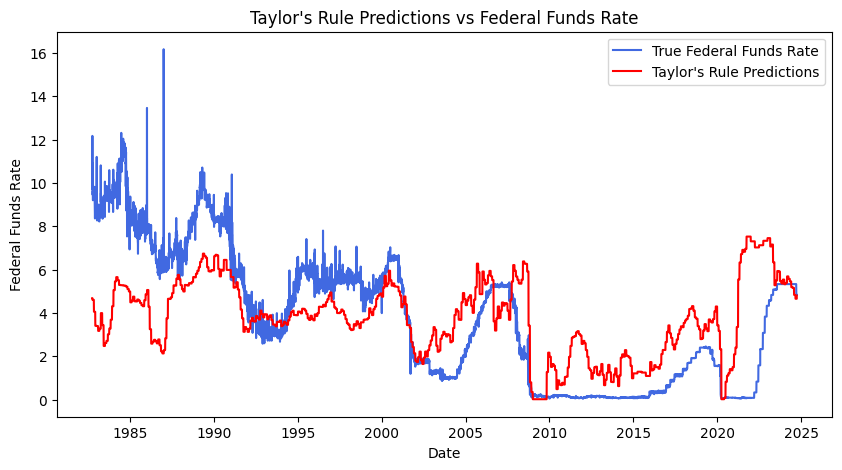

In [24]:
# Taylor Predictions vs Actual Plot
selected_model = "Taylor"

plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions[selected_model], label=f"{selected_model}'s Rule Predictions", color="red")
plt.title(f"{selected_model}'s Rule Predictions vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

Like Karakas' plots, are underpredicting in year 1990, briefly overpredicting between 1990 and 1995, before underpredicting until a bit past 2000. Around year 2002, the model begins overpredicting for the rest of the years, except between 2005 and 2010 where it underpredicts where the actual values form a peak and around 2008 or 2009.

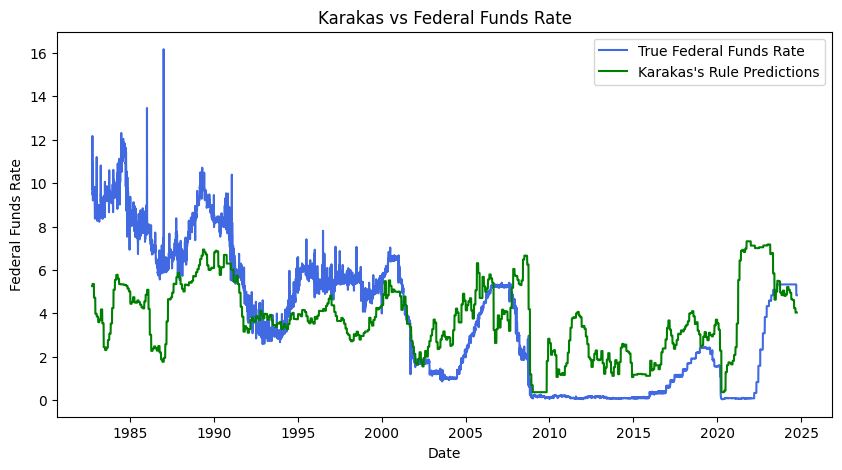

In [25]:
# Karakas Predictions vs Actual Plot
selected_model = "Karakas"

plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions[selected_model], label=f"{selected_model}'s Rule Predictions", color="green")
plt.title(f"{selected_model}'s Rule Predictions vs Federal Funds Rate")
plt.title("Karakas vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

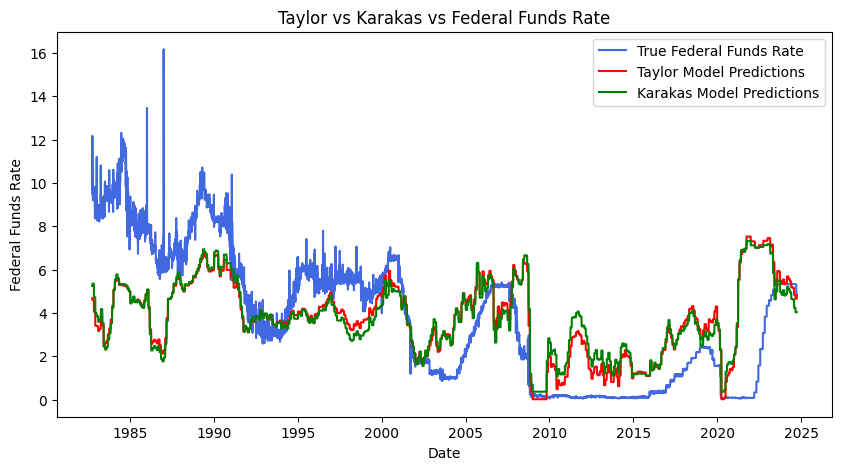

In [26]:
# Taylor Predictions vs Karakas Predictions vs Actual Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions["Taylor"], label="Taylor Model Predictions", color="red")
plt.plot(df.index, ols_predictions["Karakas"], label="Karakas Model Predictions", color="green")
plt.title("Taylor vs Karakas vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

The plots may not be an exact match but they look similar enough to the ones shared in Karakas' (2023) paper. The date range is smaller in our plots, since the addition of other variables has restricted our date range due to missing values. However, we capture similar patterns such as the Karakas Model underpredicting more than Taylor Model between 1997 to 2001 and mostly between 2010 and 2015, where there are 2 cross overs as they switch between overpredicting or underpredicting each other.

In [27]:
taylor_and_karakas = ["Taylor", "Karakas"]
for model in taylor_and_karakas:
    rs = find_resid_sum(y, ols_predictions[model])
    sae = find_sae(y, ols_predictions[model])
    print(f"{model}: ")
    print(f"\tSum of Residuals: {rs}")
    print(f"\tSum of Absolute Errors: {sae:.4f}")

Taylor: 
	Sum of Residuals: -1.8189894035458565e-11
	Sum of Absolute Errors: 29358.7040
Karakas: 
	Sum of Residuals: 1.4551915228366852e-11
	Sum of Absolute Errors: 31029.3788


Like Karakas, the metrics for Sum of Absolute errors looks close to each other. However, we got much smaller Sum of Residuals than Karakas did. That being said, both metrics for each model are very close to each other, which implies that there isn't much of a difference in performance, something that matches Karakas' findings. 

## OLS Model Metrics

In [28]:
# Initialize a list to store model statistics
model_statistics = []

# Loop through the fitted models to extract key statistics
for model_name, model in ols_fitted_models.items():
    # Extract key values
    results = {
        "model": model_name,
        "adj_r_squared": round(model.rsquared_adj, 3),
        "aic": round(model.aic, 3),
        "bic": round(model.bic, 3),
        "f_stat": round(model.fvalue, 3),
        "f_p_value": round(model.f_pvalue, 3),
        "t_p_values": model.pvalues.round(3).tolist(),
    }
    # Append the results for each model
    model_statistics.append(results)

# Convert results to a DataFrame
statistics = pd.DataFrame(model_statistics)
statistics

,model,adj_r_squared,aic,bic,f_stat,f_p_value,t_p_values
0,Taylor,0.328,71598.369,71621.285,3739.751,0.0,"[0.728, 0.0, 0.0]"
1,Karakas,0.289,72453.922,72476.837,3120.973,0.0,"[0.0, 0.0, 0.0]"
2,Target,0.904,41668.118,41698.673,48379.575,0.0,"[0.0, 0.0, 0.0, 0.0]"
3,Unemployment,0.505,66885.511,66916.065,5228.964,0.0,"[0.0, 0.0, 0.0, 0.0]"
4,Both,0.907,41308.066,41346.259,37240.048,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"


Although the results may be unreliable, we find that the Taylor Model has higher values for R-squared, adjusted R-squared, but lower values for Akaike Information Criterion (AIC), and Bayesian Information Criterion (BIC) compared to the Karakas Model. The AIC and BIC are metrics that measure model quality, while considering complexity (number of features). Generally, the model with lower values for AIC and BIC is better than the model with higher values for them. This is consistent with how the Karakas Model explains less variance than the Taylor Model, as measured by adjusted R-squared.

While the results may not be reliable, notice that the inclusion of the Unemployment variable and the Target variable raises R-Squared very greatly. The Target Variable drives up R-Squared the most. Adding Unemployment to the model after including Target (resulting in the Both Model) raises R-Squared but only by a tiny amount. The inclusion of these two variables are still worth exploring in a different model.

In [29]:
ols_error_metrics_df = pd.DataFrame(ols_error_metrics).T.round(4)
ols_error_metrics_df

,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Percentage Error,Mean Absolute Percentage Error,R-Squared
Taylor,6.217,2.493,1.913,-473.933,504.281,0.3277
Karakas,6.574,2.564,2.022,-550.486,579.147,0.2892
Target,0.884,0.940,0.605,-78.489,117.299,0.9044
Unemployment,4.573,2.138,1.669,-416.232,502.970,0.5056
Both,0.864,0.930,0.600,-85.274,119.014,0.9066


The error metrics are also in favor of the Taylor Model having better performance over the Karakas Model. Karakas (2023) claimed that their model had more accurate predictions, but not by much, which we've found is not entirely correct. Now we have a different date range than Karakas, and this could mean that Karakas' model better predicts older data, but performs poorly on more recent data. Overall, the model does not perform as well as the Taylor Model, having larger average errors and percentage errors. The difference, however, is not very big.

# Neural Network Model

In [30]:
# Initialize dictionaries to store results
nn_fitted_models = {}
nn_predictions = {}
nn_error_metrics = {}
nn_history = {}
# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in model_features.items():
    # Fit the model
    model, y_pred, history = fit_nn_model(X, y, model_name)
    
    nn_fitted_models[model_name] = model
    
    # Obtain predictions
    nn_predictions[model_name] = y_pred
    
    # Find model metrics
    metrics = error_metrics(y, y_pred)
    nn_error_metrics[model_name] = metrics

    # Save model training history
    nn_history = history

480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


## Neural Network Model Metrics

In [31]:
nn_error_metrics_df = pd.DataFrame(nn_error_metrics).T.round(4)
nn_error_metrics_df

,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Percentage Error,Mean Absolute Percentage Error,R-Squared
Taylor,4.508,2.123,1.533,-259.251,283.335,0.5126
Karakas,6.042,2.458,1.860,-509.957,537.111,0.3466
Target,0.885,0.941,0.604,-76.932,114.323,0.9043
Unemployment,3.274,1.809,1.330,-272.261,320.885,0.6460
Both,0.864,0.930,0.601,-87.584,118.621,0.9065


Our models have returned better results across the board for each model. The differences are most apparant for the Taylor and Karakas models which received a 0.2 increase in R-squared. While the increases in R-squared for the Target and Both models are less sizeable, they are rather huge considering the how high they were in the OLS model to begin with.

## Neural Network Prediction Plots

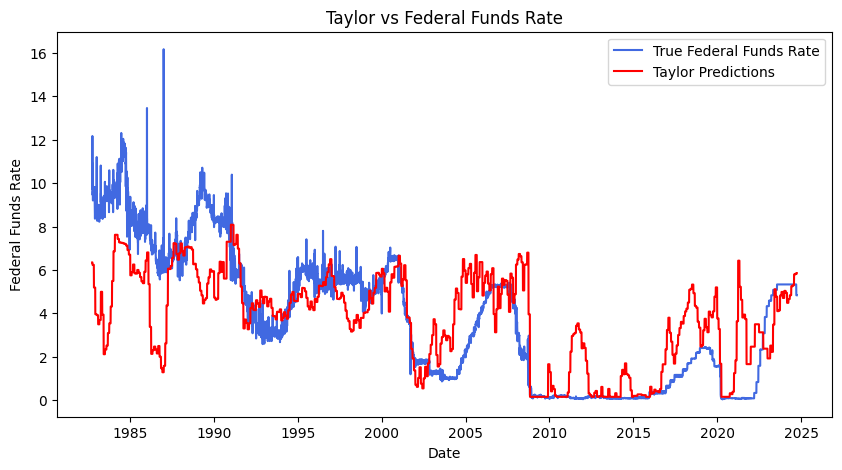

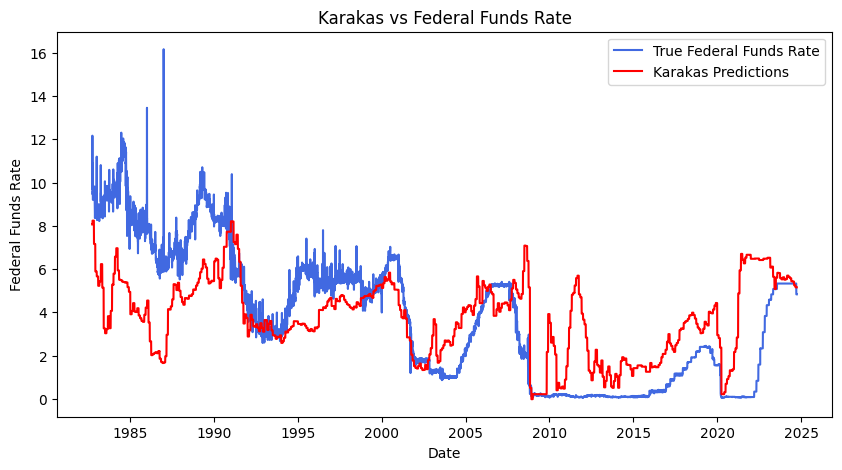

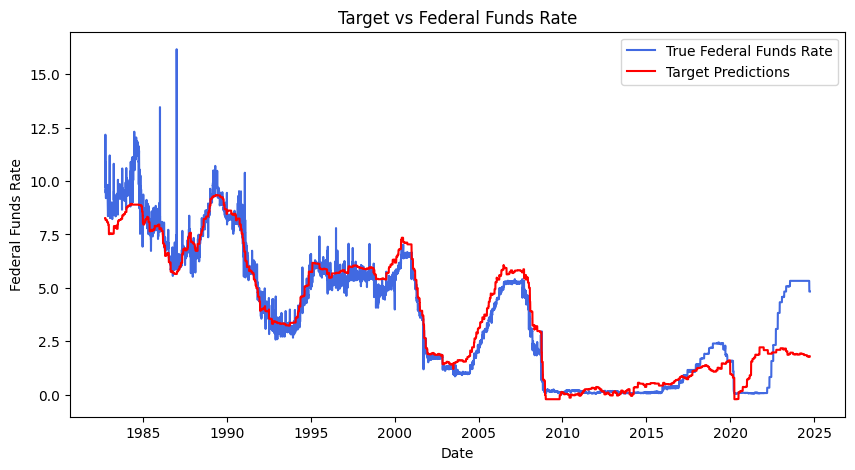

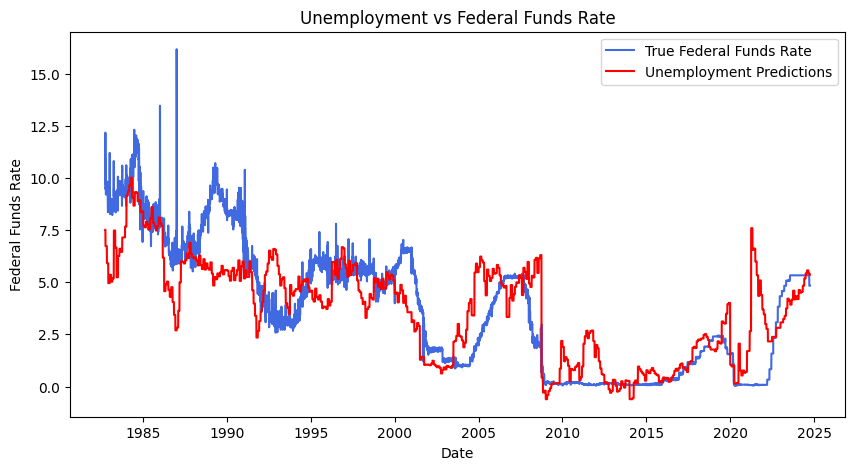

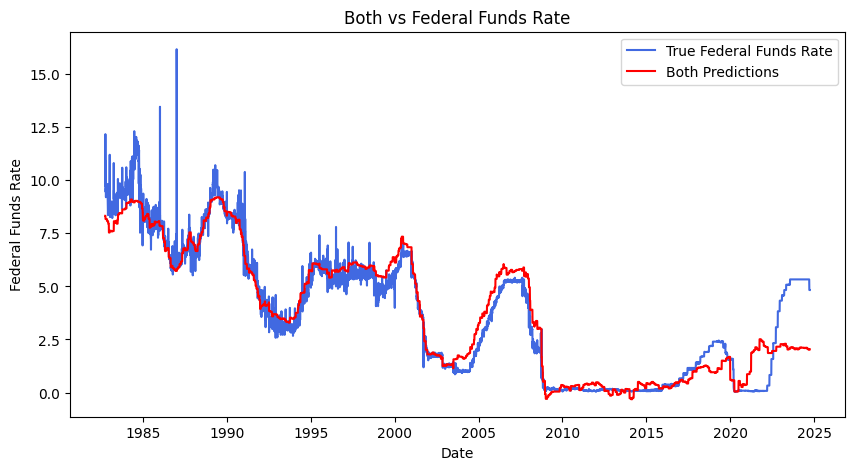

In [32]:
# Plot all neural network model predictions
for model_name, y_pred in nn_predictions.items():
    nn_predictions[model_name] = y_pred
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
    plt.plot(df.index, y_pred, label=f"{model_name} Predictions", color="red")
    plt.title(f"{model_name} vs Federal Funds Rate")
    plt.xlabel("Date")
    plt.ylabel("Federal Funds Rate")
    plt.legend()
    plt.show()

# Conclusion

Karakas (2023) noted that Taylor's Rule (and their variant) do not predict the FFR well and changed their model to neural networks, getting better predictions by capturing non-linear patterns. We note that while Karakas obtained poor results from both regression models they constructed, since all regression assumptions except for Multicollinearity have been violated, the results of those regressions are unreliable. We noticed that Karakas did not mention regression assumptions in their paper, so we decided to check them as part of the validation process. The results came as a surprise to us as we were not expecting regression assumptions to be violated. 

Through our findings from this project, we believe we can explain why both of Karakas' regression models had poor predictive performance. None of the independent variables, including but not limited to those used in Karakas' models, have a linear relationship with the FFR, which may be the reason why a non-linear model works better. 

Karakas (2023) also mentioned their model having predictions closer to the actual FFR, but not by much. However, the error metrics we computed show that it is the Taylor Model, rather than the Karakas Model that has smaller average errors and percentage errors.

We have tested (not shown in this notebook) other regression models (Generalized Least Squares and Huber regression) and transformations (Yeo-Johnson, Box-Cox, Log-transformation), but assumptions are still violated. Certain models and transformations may be able to satisfy linearity, but Normality, Homoscedastity, and Autocorrelation all remain problems. We believe that regression models are not well suited for predicting Taylor's Rule. We believe that non-linear models, such as neural networks, future research to predict the FFR should be focus on non-linear models. While the results may not be reliable due to violation of regression assumptions, it is worth noting that the inclusion of the Target and Unemployment variable did improve performance metrics.

After we created the neural network models, we found a similar pattern in model performance level: Karakas < Taylor < Unemployment < Target < Both. However, we now have more reliable metrics. While there was better performance from each model compared to the OLS model, we obtained significantly better performance with the inclusion of Unemployment and Target. However, the Target feature had a bigger effect on the model performance.

# References

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Effective Rate [DFF]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFF

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Rate (DISCONTINUED) [DFEDTAR]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTAR

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Range - Lower Limit [DFEDTARL]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTARL

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Range - Upper Limit [DFEDTARU]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTARU

Karakas, A. D. (2023). Reevaluating the Taylor Rule with Machine Learning. ArXiv.org. https://arxiv.org/abs/2302.08323

U.S. Bureau of Economic Analysis. (2025). Real Gross Domestic Product [GDPC1]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/GDPC1

U.S. Bureau of Labor Statistics. (2025). Consumer Price Index for all urban consumers: All items in U.S. city average [CPIAUCSL]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/CPIAUCSL

U.S. Bureau of Labor Statistics. (2025). Unemployment Rate [UNRATE]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/UNRATE

U.S. Congressional Budget Office. (2025). Real Potential Gross Domestic Product [GDPPOT]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/GDPPOT